# Sample solutions

https://www.nature.com/articles/s41467-019-13056-x

In [1]:
%matplotlib inline
%load_ext memory_profiler
import numpy as np
from scipy import sparse
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib as mpl
from yellowbrick.style import rcmod
from scipy.stats import spearmanr
from memory_profiler import profile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

In /Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


In [2]:
# Yellowbrick changes the plotting settings, reset to default here
rcmod.reset_orig()

/Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/jacob/opt/anacond

# Problem 1

1. Load the data

In [3]:
X = np.load("../data/p2_unsupervised/X.npy")
#y = np.load("../data/p2_unsupervised/y.npy")

In [4]:
# 511 cells, 45768 genes
print(X.shape)

(2169, 45768)


In [5]:
# Largest entry of first column
np.max(X[:,0])

61.77721743231262

2. Log transform

In [6]:
# Log 
X_log = np.log2(X + 1)

In [7]:
# Largest entry of first column
print(np.max(X_log[:,0]))

5.972169178513185


3. Full PCA, raw vs transformed data

In [8]:
%%timeit -n 1 -r 1
%%memit -r 1
pca = PCA().fit(X)
pca_log = PCA().fit(X_log)

peak memory: 3325.74 MiB, increment: 2151.21 MiB
52.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
# A = np.array([1, 1, 0, 0, 0, 1, 1, 0, 0]).reshape(3, 3)
# A2 = A@A
# print(A2)

# A3 = A2@A
# print(A3)

In [10]:
# Percentage of variance explained by first component
print("First component raw:", pca.explained_variance_ratio_[0])
print(pca.explained_variance_ratio_.shape)
print("First component log:", pca_log.explained_variance_ratio_[0])
print(pca.explained_variance_ratio_.shape)

#print(pca.components_.shape)

First component raw: 0.4263822617018597
(2169,)
First component log: 0.1549493716242621
(2169,)


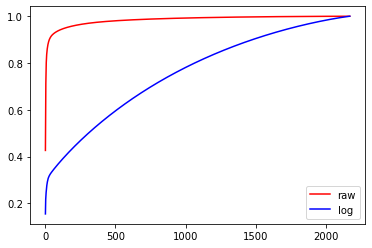

In [11]:
# Cumulative variance explained plots
plt.plot(range(1, X.shape[0]+1), np.cumsum(pca.explained_variance_ratio_), color="red", label="raw")
plt.plot(range(1, X.shape[0]+1), np.cumsum(pca_log.explained_variance_ratio_), color="blue", label="log")
plt.legend()
plt.show()

In [12]:
# 85% variance cutoffs
print("Raw:", np.where(np.cumsum(pca.explained_variance_ratio_) >= .85)[0][0] + 1)
#print(np.where(np.cumsum(pca.explained_variance_ratio_) >= .85))
print("Log:", np.where(np.cumsum(pca_log.explained_variance_ratio_) >= .85)[0][0] + 1)

Raw: 12
Log: 1253


Remember that we want to find genes that can differentiate between cells, even if the genes are not expressed in many cells and/or have low levels of expression. For example, if a particular gene has $0$ expression for $80$ cells and $0.2$ expression for $20$ cells, that would contribute much less to the variance than a gene with $0$ expression for $50$ cells and $0.8$ expression for $50$ cells. While the latter gene might just differentiate between neuron vs non-neuron (for example),  the former gene might differentiate between specific cell types.  But the variances differ greatly and we don't want to make the conclusion that the latter gene is sufficient for explaining the variation between cells in the data.

4. Plotting without visualization techniques

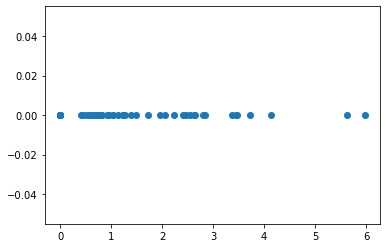

In [13]:
# Nothing informative!
plt.scatter(X_log[:,0],X_log[:,1])

5. PCA visualization

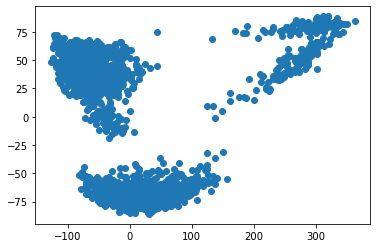

In [14]:
# Three visually distinct clusters. Could potentially argue for 4 or 5 as well, but these are not well-separated

# print(X_log.shape)
# print(pca_log)
z = pca_log.transform(X_log)
# print(z.shape)
# print(z[:6, :])
# print(z[:, 0])
plt.scatter(z[:,0],z[:,1])

6. MDS (sklearn version is nonlinear)

41177369069.212944


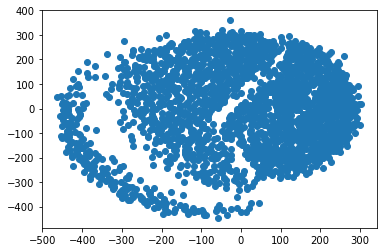

In [15]:
# Since there is randomization in the initial state, run this multiple times 
# and use the result with the best objective function value.  
# (Also be aware that some initializations can give you suboptimal local minima for both MDS and T-SNE algorithms). 
#We still see 3 distinct clusters.  
mds_class=MDS(n_components=2)
mds=mds_class.fit_transform(X_log)
print(mds_class.stress_)
stress = mds_class.stress_
plt.scatter(mds[:,0],mds[:,1])

In [16]:
# ## Manual calculus of sklearn stress
# DE = euclidean_distances(points)
# stress = 0.5 * numpy.sum((DE - data.values)**2)
# print("Manual calculus of sklearn stress :")
# print(stress)
# print("")

## Kruskal's stress (or stress formula 1)
stress1 = np.sqrt(stress / (0.5 * np.sum(X**2)))
print("Kruskal's Stress :")
print("[Poor > 0.2 > Fair > 0.1 > Good > 0.05 > Excellent > 0.025 > Perfect > 0.0]")
print(stress1)
print("")

Kruskal's Stress :
[Poor > 0.2 > Fair > 0.1 > Good > 0.05 > Excellent > 0.025 > Perfect > 0.0]
0.14098894022769032



7. T-SNE

0.4942883849143982


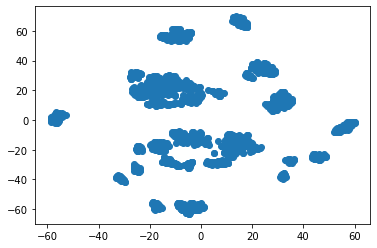

In [17]:
# Emergence of at least 5 clusters. 
# Since there is randomization in the initial state, 
# run this multiple times and use the result with the best objective function value.  
# (Also be aware that some initializations can give you suboptimal local minima for both MDS and T-SNE algorithms).

z_tsne_class = TSNE(n_components=2,perplexity=40)
z_tsne=z_tsne_class.fit_transform(z[:,0:50])
print(z_tsne_class.kl_divergence_)
plt.scatter(z_tsne[:,0],z_tsne[:,1])


8. K-Means: From the T-SNE plot (with the lowest KL-divergence), we can see the emergence of 5 clusters. 


In [18]:
# K-means with n=5, as decided from T-SNE plot above; 
# Run multiple times and explore settings to get the lowest inertia_, such aa:
# init='random', or random_state=0  
kmeans = KMeans(18, tol=1e-6) 
kmeans.fit(z[:,0:50])
print(kmeans.inertia_)
print(kmeans.labels_)

11140540.402292911
[3 6 6 ... 1 1 1]


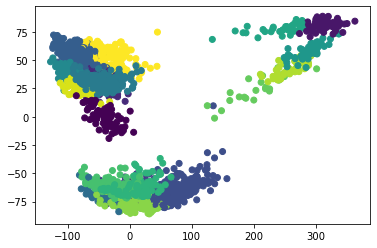

In [19]:
#PCA plot colored with K-means clusters
plt.scatter(z[:,0],z[:,1], c=kmeans.labels_)

41379678794.56958


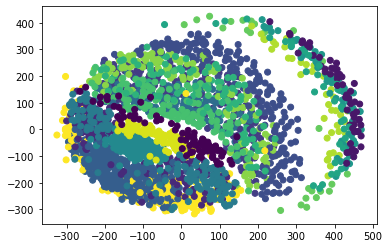

In [20]:
# MDS plot with 5 K-means clusters, on log-transformed data:
mds=mds_class.fit_transform(X_log)
print(mds_class.stress_)
plt.scatter(mds[:,0],mds[:,1],c=kmeans.labels_)

4928189227.977356


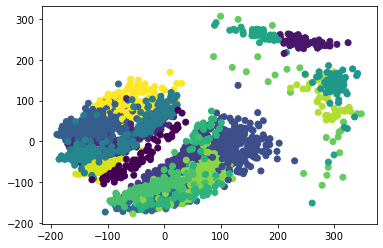

In [21]:
# Alternatively, MDS on first 50 PCS of log-transformed data
# colored with the 5 K-means clusters:
mds_class=MDS(n_components=2)
mds=mds_class.fit_transform(z[:,0:50])
print(mds_class.stress_)
plt.scatter(mds[:,0],mds[:,1],c=kmeans.labels_)

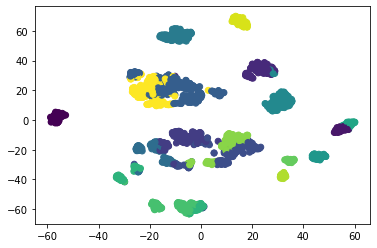

In [22]:
# T-SNE on first 50 PCS of log-transformed data,
# colored with 4 K-means clusters 

plt.scatter(z_tsne[:,0],z_tsne[:,1], c=kmeans.labels_)

In [23]:
# Preparing logistic regression
target_labels = kmeans.labels_
print(target_labels.shape)

## Spliting training and test data
X_tn, X_te, Y_tn, Y_te = train_test_split(X_log, target_labels, random_state=0)

## Data standardization
std_scale = StandardScaler()
std_scale.fit(X_tn)
X_tn_std = std_scale.transform(X_tn)
X_te_std = std_scale.transform(X_te)


(2169,)


In [25]:
clf_logi_l1 = LogisticRegression(C=0.01, penalty='l1',solver='liblinear')

Y_tn[Y_tn != 0] = 1
Y_te[Y_te != 0] = 1

clf_logi_l1.fit(X_tn_std, Y_tn)

pred_logistic_l1 = clf_logi_l1.predict(X_te_std)

precision_l1 = precision_score(Y_te, pred_logistic_l1, average='weighted')

print(precision_l1)

class_report_l1 = classification_report(Y_te, pred_logistic_l1)
print(class_report_l1)

0.9981618939170286
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       1.00      1.00      1.00       523

    accuracy                           1.00       543
   macro avg       1.00      0.97      0.99       543
weighted avg       1.00      1.00      1.00       543



In [24]:
clf_logi_l2 = LogisticRegression(C=0.01, penalty='l2',solver='liblinear')

Y_tn[Y_tn != 0] = 1
Y_te[Y_te != 0] = 1

clf_logi_l2.fit(X_tn_std, Y_tn)

pred_logistic_l2 = clf_logi_l2.predict(X_te_std)

precision_l2 = precision_score(Y_te, pred_logistic_l2, average='weighted')

print(precision_l2)

class_report_l2 = classification_report(Y_te, pred_logistic_l2)
print(class_report_l2)

0.9754450583179864
              precision    recall  f1-score   support

           0       0.33      1.00      0.50        20
           1       1.00      0.92      0.96       523

    accuracy                           0.93       543
   macro avg       0.67      0.96      0.73       543
weighted avg       0.98      0.93      0.94       543



In [30]:
l1_ratio = 0.5
clf_logi_e = LogisticRegression(C=0.01, penalty='elasticnet', solver='saga', l1_ratio=l1_ratio)

Y_tn[Y_tn != 0] = 1
Y_te[Y_te != 0] = 1

clf_logi_e.fit(X_tn_std, Y_tn)

pred_logistic_e = clf_logi_e.predict(X_te_std)

precision_e = precision_score(Y_te, pred_logistic_e, average='weighted')

print(precision_e)

class_report_e = classification_report(Y_te, pred_logistic_e)
print(class_report_e)

0.9982460755941419
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      1.00      1.00       523

    accuracy                           1.00       543
   macro avg       0.98      1.00      0.99       543
weighted avg       1.00      1.00      1.00       543



/Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [32]:
print(precision_l1, precision_l2, precision_e)

0.9981618939170286 0.9754450583179864 0.9982460755941419


In [79]:
### Extract top 100 features in terms of coefficients (after abs)

coeff = clf_logi_e.coef_
print(coeff)
print(coeff.shape)

coeff_abs = np.abs(coeff)
rank = coeff_abs.argsort()[::-1]
# print(rank)
print(rank)
print(rank[0, :100].shape)

# print(X_log.shape)

# X_log_top100 = X_log[:, rank[0, :100]]
# print(X_log_top100.shape)

[[0. 0. 0. ... 0. 0. 0.]]
(1, 45768)
[[    0 30488 30489 ... 31904 30220 35062]]
(100,)
(2169, 100)


In [101]:
### Applying the rank of feature into new evaluation dataset

X_tn_e = np.load("../data/p2_evaluation/X_train.npy")
X_te_e = np.load("../data/p2_evaluation/X_test.npy")
Y_tn_e = np.load("../data/p2_evaluation/Y_train.npy")
Y_te_e = np.load("../data/p2_evaluation/Y_test.npy")

X_tn_e_log = np.log2(X_tn_e + 1)
X_te_e_log = np.log2(X_te_e + 1)
Y_tn_e_log = np.log2(Y_tn_e + 1)
Y_te_e_log = np.log2(Y_te_e + 1)

print(X_tn_e.shape)
print(X_te_e.shape)
print(Y_tn_e.shape)
print(Y_te_e.shape)

(1077, 45768)
(1108, 45768)
(1077,)
(1108,)


In [108]:
### Extracting top 100 features abide by the rank_abs
X_tn_e_log_top100 = X_tn_e_log[:, rank[0, :100]]
X_te_e_log_top100 = X_te_e_log[:, rank[0, :100]]
print(X_tn_e_log_top100.shape)
print(X_te_e_log_top100.shape)

(1077, 100)
(1108, 100)


In [103]:
print(Y_tn_e_log.shape)
print(type(Y_tn_e_log))

print(X_tn_e_log_top100.shape)
print(type(X_tn_e_log_top100))

(1077,)
<class 'numpy.ndarray'>
(1077, 100)
<class 'numpy.ndarray'>


In [112]:
l1_ratio = 0.5
clf_logi_top100_e = LogisticRegression(C=0.01, penalty='elasticnet', solver='saga', l1_ratio=l1_ratio)

# print(clf_logi_top100_e)

Y_tn_e_log[Y_tn_e_log != 0] = 1
Y_te_e_log[Y_te_e_log != 0] = 1

clf_logi_top100_e.fit(X_tn_e_log_top100, Y_tn_e_log)
# print(X_tn_e_log_top100.shape)
# print(X_te_e_log_top100.shape)

print(X_te_e_log_top100.shape)
pred_logistic_e_top100 = clf_logi_top100_e.predict(X_te_e_log_top100)

precision_e_top100 = precision_score(Y_te_e_log, pred_logistic_e_top100, average='weighted')

print(precision_e_top100)

class_report_e_top100 = classification_report(Y_te_e_log, pred_logistic_e_top100)
print(class_report_e_top100)

(1108, 100)
0.9695494858528065
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        17
         1.0       0.98      1.00      0.99      1091

    accuracy                           0.98      1108
   macro avg       0.49      0.50      0.50      1108
weighted avg       0.97      0.98      0.98      1108



/Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [126]:
import random

rand100 = np.arange(1, 101)
np.random.shuffle(rand100)

X_tn_e_log_rnd100 = X_tn_e_log[:, rand100]
X_te_e_log_rnd100 = X_te_e_log[:, rand100]
print(X_tn_e_log_rnd100.shape)
print(X_te_e_log_rnd100.shape)

(1077, 100)
(1108, 100)


In [128]:
l1_ratio = 0.5
clf_logi_e_ev = LogisticRegression(C=0.01, penalty='elasticnet', solver='saga', l1_ratio=l1_ratio)

# print(clf_logi_top100_e)

Y_tn_e_log[Y_tn_e_log != 0] = 1
Y_te_e_log[Y_te_e_log != 0] = 1

clf_logi_e_ev.fit(X_tn_e_log_rnd100, Y_tn_e_log)
# print(X_tn_e_log_top100.shape)
# print(X_te_e_log_top100.shape)

print(X_te_e_log_rnd100.shape)
pred_logistic_e_ev_rnd100 = clf_logi_e_ev.predict(X_te_e_log_rnd100)

precision_e_ev_rnd100 = precision_score(Y_te_e_log, pred_logistic_e_ev_rnd100, average='weighted')

print(precision_e_ev_rnd100)

class_report_e_ev_rnd100 = classification_report(Y_te_e_log, pred_logistic_e_ev_rnd100)
print(class_report_e_ev_rnd100)

(1108, 100)
0.9695494858528065
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        17
         1.0       0.98      1.00      0.99      1091

    accuracy                           0.98      1108
   macro avg       0.49      0.50      0.50      1108
weighted avg       0.97      0.98      0.98      1108



/Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacob/opt/anaconda3/envs/6.86x/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [130]:
var_coeff = np.var(X_tn_e_log_top100, axis = 0)
var_rand100 = np.var(X_tn_e_log_rnd100, axis = 0)

print(var_coeff.shape)

(100,)


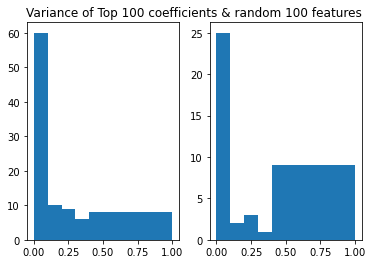

In [148]:
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)

ax0.hist(var_coeff, bins = [0,0.1,0.2,0.3,0.4,1]) 
plt.title('Variance of Top 100 coefficients & random 100 features', loc='right')
ax1.hist(var_rand100, bins = [0,0.1,0.2,0.3,0.4,1]) 
# ax1.title("Random 100 features") 
plt.show()

Parameter control

In [ ]:
# K-means with n=5, as decided from T-SNE plot above; 
# Run multiple times and explore settings to get the lowest inertia_, such aa:
# init='random', or random_state=0  
kmeans = KMeans(18, tol=1e-6) 
kmeans.fit(z[:,0:10])
print(kmeans.inertia_)
print(kmeans.labels_)

# T-SNE on first 50 PCS of log-transformed data,
# colored with 4 K-means clusters 

plt.scatter(z_tsne[:,0],z_tsne[:,1], c=kmeans.labels_)

In [ ]:
# K-means with n=5, as decided from T-SNE plot above; 
# Run multiple times and explore settings to get the lowest inertia_, such aa:
# init='random', or random_state=0  
kmeans = KMeans(18, tol=1e-6) 
kmeans.fit(z[:,0:50])
print(kmeans.inertia_)
print(kmeans.labels_)

# T-SNE on first 50 PCS of log-transformed data,
# colored with 4 K-means clusters 

plt.scatter(z_tsne[:,0],z_tsne[:,1], c=kmeans.labels_)

In [ ]:
# K-means with n=5, as decided from T-SNE plot above; 
# Run multiple times and explore settings to get the lowest inertia_, such aa:
# init='random', or random_state=0  
kmeans = KMeans(18, tol=1e-6) 
kmeans.fit(z[:,0:100])
print(kmeans.inertia_)
print(kmeans.labels_)

# T-SNE on first 50 PCS of log-transformed data,
# colored with 4 K-means clusters 

plt.scatter(z_tsne[:,0],z_tsne[:,1], c=kmeans.labels_)

In [ ]:
# K-means with n=5, as decided from T-SNE plot above; 
# Run multiple times and explore settings to get the lowest inertia_, such aa:
# init='random', or random_state=0  
kmeans = KMeans(18, tol=1e-6) 
kmeans.fit(z[:,0:250])
print(kmeans.inertia_)
print(kmeans.labels_)

# T-SNE on first 50 PCS of log-transformed data,
# colored with 4 K-means clusters 

plt.scatter(z_tsne[:,0],z_tsne[:,1], c=kmeans.labels_)

In [ ]:
# K-means with n=5, as decided from T-SNE plot above; 
# Run multiple times and explore settings to get the lowest inertia_, such aa:
# init='random', or random_state=0  
kmeans = KMeans(18, tol=1e-6) 
kmeans.fit(z[:,0:500])
print(kmeans.inertia_)
print(kmeans.labels_)

# T-SNE on first 50 PCS of log-transformed data,
# colored with 4 K-means clusters 

plt.scatter(z_tsne[:,0],z_tsne[:,1], c=kmeans.labels_)

9. Elbow method.

Num clusters 2 Inertia: 1324940986487.123
Num clusters 3 Inertia: 1095534354707.602
Num clusters 4 Inertia: 932183356160.7363
Num clusters 5 Inertia: 789991510302.7004
Num clusters 6 Inertia: 679224900207.1495
Num clusters 7 Inertia: 616595125931.1931
Num clusters 8 Inertia: 565014405372.9044
Num clusters 9 Inertia: 517287344304.9071


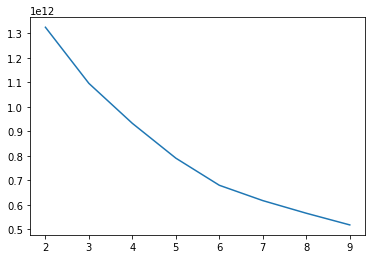

In [ ]:
# Would select 3, 4, or 5 clusters
all_kmeans = [i for i in range(8)]
#print(all_kmeans)
for i in range(8):
    cur_kmeans = KMeans(i+2)
    cur_kmeans.fit(z[:,0:50])
    print("Num clusters", i+2, "Inertia:", cur_kmeans.inertia_)
    all_kmeans[i] = cur_kmeans
plt.plot([i+2 for i in range(8)], [all_kmeans[i].inertia_ for i in range(8)])

10. Hierarchical clustering: Dendrogram in R script

11. MDS on cluster means. Confirms 3 groups, one with 1 cluster and two with 2 clusters each. Accurate representation of distances - one cluster is far away from others, indicating a different type of cell. But T-SNE consistently puts it in the middle of the plot.

In [ ]:
# MDS on kmeans cluster means

#print(X_log.shape[1])
cmeans = np.zeros((5,X_log.shape[1]))
for c in range(5):
    cmeans[c] = np.mean(X_log[np.where(kmeans.labels_==c)[0]],axis=0)
#print(X_log[np.where(kmeans.labels_==c)[0]].shape)
# print(kmeans.labels_.shape)
# print(X_log[np.where(kmeans.labels_==2)[0]])

breaking at iteration 52 with stress 3088.707998411127
breaking at iteration 74 with stress 4591.189938624161
breaking at iteration 33 with stress 3088.937696244951
breaking at iteration 71 with stress 3088.7079298256804


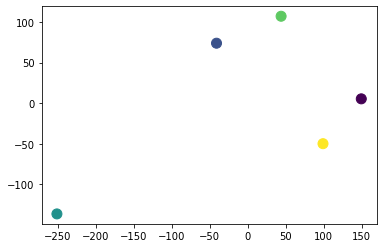

In [ ]:
mds = MDS(n_components=2,verbose=1,eps=1e-5)
mds.fit(cmeans)
plt.scatter(mds.embedding_[:,0],mds.embedding_[:,1],c=[1,2,3,4,5],s=100)

In MDS, we see one group with 1 cluster mean and two groups with 2 cluster means each. MDS aim to respresent distances accurately.  The one cluster that far away from the other indicates a different type of cell.

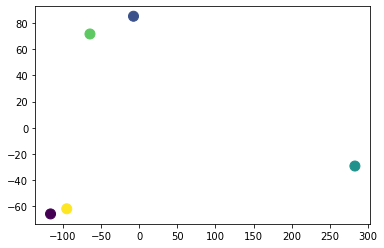

In [ ]:
# PCA on cluster means
z_means = PCA(2).fit_transform(cmeans)
plt.scatter(z_means[:,0],z_means[:,1],c=[0,1,2,3,4],s=100)

Similarly, in PCA,  we again see one group with 1 cluster mean and two groups with 2 cluster means each. PCA is a linear projection, hence the distances in the PC directions are preserved.  The one cluster that far away from the other indicates a different type of cell.

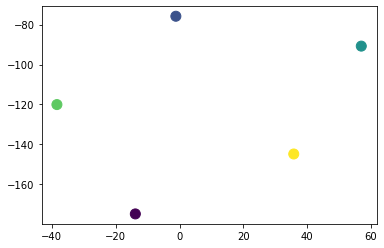

In [ ]:
# Emergence of at least 5 clusters. 
z_means_tsne = TSNE(n_components=2,perplexity=40).fit_transform(cmeans)
plt.scatter(z_means_tsne[:,0],z_means_tsne[:,1],c=[0,1,2,3,4],s=100)

T-SNE does not represent distances accurately.  The hierarchical structure of the 5 clusters falling into 3 groups are lost.   (on the other hand, we saw that the 5 clusters are well separated.)

12. PCA/T-SNE on Raw Data

In [ ]:
pca = PCA(50).fit(X)
z = pca.transform(X)
plt.scatter(z[:,0],z[:,1], c=y)

NameError: name 'y' is not defined

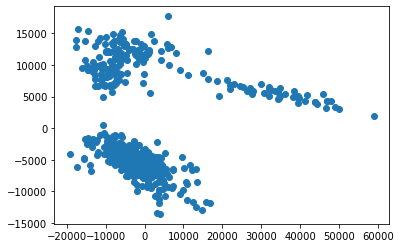

In [ ]:
pca = PCA(50).fit(X)
z = pca.transform(X)
plt.scatter(z[:,0],z[:,1])

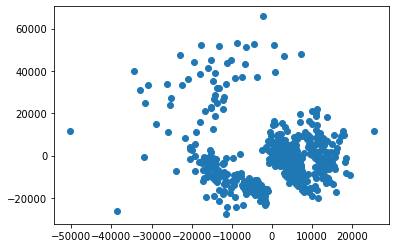

In [ ]:
mds = MDS(n_components=2,verbose=1,eps=1e-5)
mds.fit(z[:,0:50])
plt.scatter(mds.embedding_[:,0],mds.embedding_[:,1])

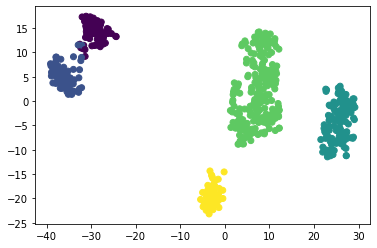

In [ ]:
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:50])
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=y)

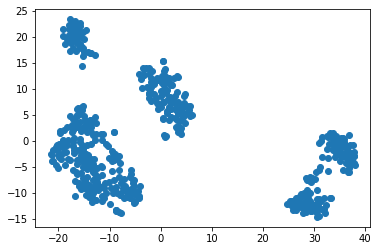

In [ ]:
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:50])
plt.scatter(z_tsne[:,0],z_tsne[:,1])

The log transformed data produced more clearly defined clusters. This typically happens for this type of data.  